Define the device:

In [1]:
import os
import torch
import warnings
warnings.filterwarnings('ignore')

gpu_list = [0]
gpu_list_str = ','.join(map(str, gpu_list))
os.environ.setdefault("CUDA_VISIBLE_DEVICES", gpu_list_str)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Define the `Hist2Cell` model:

In [2]:
from torch.nn import Linear
import torch.nn as nn
import torchvision.models as models
from torch_geometric.nn import GATv2Conv, LayerNorm
import sys,os
sys.path.append(os.path.dirname(os.getcwd()))
from model.ViT import Mlp, VisionTransformer


class Hist2Cell(nn.Module):
    def __init__(self, cell_dim=80, vit_depth=3):
        super(Hist2Cell, self).__init__()
        self.resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.resnet18 = torch.nn.Sequential(*list(self.resnet18.children())[:-1])
        
        self.embed_dim = 32 * 8
        self.head = 8
        self.dropout = 0.3
        
        self.conv1 = GATv2Conv(in_channels=512, out_channels=int(self.embed_dim/self.head), heads=self.head)
        self.norm1 = LayerNorm(in_channels=self.embed_dim)
        
        self.cell_transformer = VisionTransformer(num_classes=cell_dim, embed_dim=self.embed_dim, depth=vit_depth,
                                                  mlp_head=True, drop_rate=self.dropout, attn_drop_rate=self.dropout)
        self.spot_fc = Linear(in_features=512, out_features=256)
        self.spot_head = Mlp(in_features=256, hidden_features=512*2, out_features=cell_dim)
        self.local_head = Mlp(in_features=256, hidden_features=512*2, out_features=cell_dim)
        self.fused_head = Mlp(in_features=256, hidden_features=512*2, out_features=cell_dim)
    
    
    def forward(self, x, edge_index):
        x_spot = self.resnet18(x)
        x_spot = x_spot.squeeze()
        
        x_local = self.conv1(x=x_spot, edge_index=edge_index)
        x_local = self.norm1(x_local)
        
        x_local = x_local.unsqueeze(0)
        
        x_cell = x_local
        
        x_spot = self.spot_fc(x_spot)
        cell_predication_spot = self.spot_head(x_spot)
        x_local = x_local.squeeze(0)
        cell_prediction_local = self.local_head(x_local)
        cell_prediction_global, x_global = self.cell_transformer(x_cell)
        cell_prediction_global = cell_prediction_global.squeeze()
        x_global = x_global.squeeze()
        cell_prediction_fused = self.fused_head((x_spot+x_local+x_global)/3.0)
        cell_prediction = (cell_predication_spot + cell_prediction_local + cell_prediction_global + cell_prediction_fused) / 4.0
            
        cell_prediction = torch.relu(cell_prediction)
        
        return cell_prediction

Load the checkpoint weights in the Leave-A50-out experiments for human lung cell2location dataset:

In [3]:
case = "A50"

model = Hist2Cell(vit_depth=3)
checkpoint = torch.load("../model_weights/humanlung_cell2location_leave_"+case+"_out.pth")
model.load_state_dict(checkpoint)
model = model.to(device)

Load test split file, there are 2 slides from donor A50 in humanlung cell2location dataset: 
- WSA_LngSP9258463
- WSA_LngSP9258467

In [4]:
test_slides = open("../train_test_splits/humanlung_cell2location/test_leave_"+case+".txt").read().split('\n')
test_slides

['WSA_LngSP9258463', 'WSA_LngSP9258467']

Load and create the `Dataloader` for the processed data of each slide, save the predictions and calculate the pearson R for 80 fine-grained cell types:

In [5]:
from torch_geometric.loader import NeighborLoader
from tqdm import tqdm
import torch_geometric
torch_geometric.typing.WITH_PYG_LIB = False
from torch_geometric.data import Batch
import numpy as np
from scipy.stats import pearsonr


hop = 2
subgraph_bs = 16
test_graph_list = list()
for item in test_slides:
    test_graph_list.append(torch.load(os.path.join("../example_data/humanlung_cell2location", item+'.pt')))
test_dataset = Batch.from_data_list(test_graph_list)

test_loader = NeighborLoader(
    test_dataset,
    num_neighbors=[-1]*hop,
    batch_size=subgraph_bs,
    directed=False,
    input_nodes=None,
    shuffle=False,
    num_workers=2,
)

with torch.no_grad():
    model.eval()
    test_cell_pred_array = []
    test_cell_label_array = []
    test_cell_pos_array = []
    for graph in tqdm(test_loader):
        x = graph.x.to(device)
        y = graph.y.to(device)
        pos = graph.pos.to(device)
        edge_index = graph.edge_index.to(device)
        cell_label = y[:, 250:]
        cell_pred = model(x=x, edge_index=edge_index)

        center_num = len(graph.input_id)
        center_cell_label = cell_label[:center_num, :]
        center_cell_pred = cell_pred[:center_num, :]
        center_cell_pos = pos[:center_num, :]
        
        test_cell_label_array.append(center_cell_label.squeeze().cpu().detach().numpy())
        test_cell_pred_array.append(center_cell_pred.squeeze().cpu().detach().numpy())
        test_cell_pos_array.append(center_cell_pos.squeeze().cpu().detach().numpy())
        

    if len(test_cell_pred_array[-1].shape) == 1:
        test_cell_pred_array[-1] = np.expand_dims(test_cell_pred_array[-1], axis=0)
    test_cell_pred_array = np.concatenate(test_cell_pred_array)
    if len(test_cell_label_array[-1].shape) == 1:
        test_cell_label_array[-1] = np.expand_dims(test_cell_label_array[-1], axis=0)
    test_cell_label_array = np.concatenate(test_cell_label_array)
    if len(test_cell_pos_array[-1].shape) == 1:
        test_cell_pos_array[-1] = np.expand_dims(test_cell_pos_array[-1], axis=0)
    test_cell_pos_array = np.concatenate(test_cell_pos_array)
    

Predictions = dict()
for slide_no in range(len(test_slides)):
    indices = np.where(test_dataset.batch.numpy() == slide_no)
    test_cell_pred_array_sub = test_cell_pred_array[indices]
    test_cell_label_array_sub = test_cell_label_array[indices]
    test_cell_pos_arraay_sub = test_cell_pos_array[indices]
    
    test_cell_abundance_all_pearson_average = 0.0
    test_cell_pearson_list = []
    for i in range(test_cell_pred_array_sub.shape[1]):
        r, p = pearsonr(test_cell_pred_array_sub[:, i], test_cell_label_array_sub[:, i])
        test_cell_abundance_all_pearson_average = test_cell_abundance_all_pearson_average + r
        test_cell_pearson_list.append(r)
    test_cell_abundance_all_pearson_average = test_cell_abundance_all_pearson_average / test_cell_pred_array_sub.shape[1]
    
    Predictions[test_slides[slide_no]] = {
        'cell_abundance_predictions': test_cell_pred_array_sub,
        'cell_abundance_labels': test_cell_label_array_sub,
        'coords': test_cell_pos_arraay_sub,
    }
    
    print("slide %s has PCC:%f" % (test_slides[slide_no], test_cell_abundance_all_pearson_average)) 

100%|██████████| 51/51 [00:05<00:00,  9.72it/s]


slide WSA_LngSP9258463 has PCC:0.283857
slide WSA_LngSP9258467 has PCC:0.367411


In [6]:
Predictions.keys()

dict_keys(['WSA_LngSP9258463', 'WSA_LngSP9258467'])

Under the prediction of each slide, we have the labels and predictions for the 80 fine-grained cell types of each spot, and the spatial coordinate of each spot:

In [7]:
Predictions['WSA_LngSP9258467'].keys()

dict_keys(['cell_abundance_predictions', 'cell_abundance_labels', 'coords'])

Visualize the predictions of `Hist2Cell` in `Fig 3b`, `Fig 3a` and `Supp Fig 4`.

In [8]:
import matplotlib.pyplot as plt
from PIL import Image


def plot_cell_abundance(img, X, Y, cell_abundance, cell_name, cmap='viridis', s=95):
    fig, ax = plt.subplots()
    ax.imshow(img.transpose(Image.FLIP_TOP_BOTTOM).transpose(Image.FLIP_LEFT_RIGHT))

    sc = ax.scatter(img.size[0] - (X), img.size[1] - (Y),
                    c=cell_abundance,
                    s=s, alpha=0.80, cmap=cmap)

    ax.set_xlim(img.size[0] - (min(X)-50), img.size[0] - (max(X)+50))
    ax.set_ylim(img.size[1] - (min(Y)-50), img.size[1] - (max(Y)+50))
    ax.set_ylim(ax.get_ylim()[::-1])

    ax.set_xticks([])
    ax.set_yticks([])

    cbar = plt.colorbar(sc, ax=ax)

    cbar.ax.tick_params(labelsize=14)
    
    ax.set_title(cell_name, fontsize=16)  
    
    plt.show()

  0%|          | 0/11 [00:00<?, ?it/s]

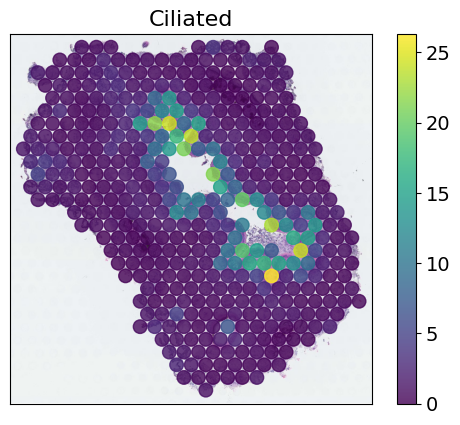

  9%|▉         | 1/11 [00:02<00:21,  2.10s/it]

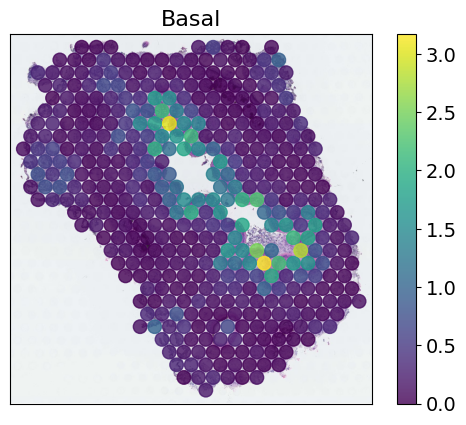

 18%|█▊        | 2/11 [00:03<00:17,  1.91s/it]

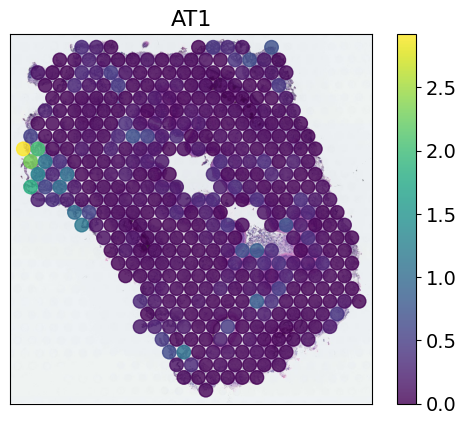

 27%|██▋       | 3/11 [00:05<00:14,  1.86s/it]

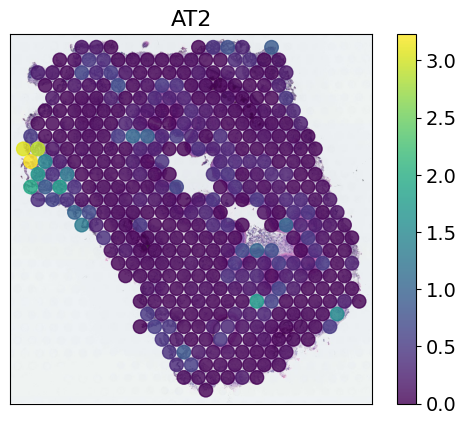

 36%|███▋      | 4/11 [00:07<00:12,  1.81s/it]

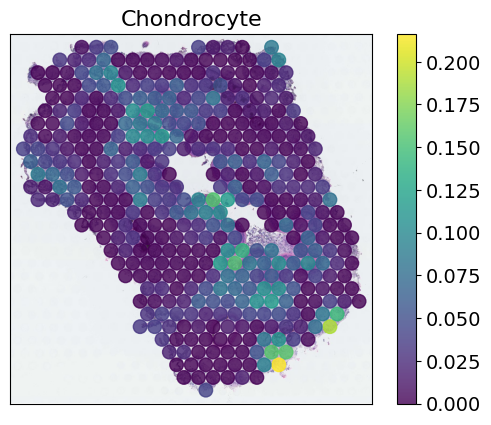

 45%|████▌     | 5/11 [00:09<00:11,  1.86s/it]

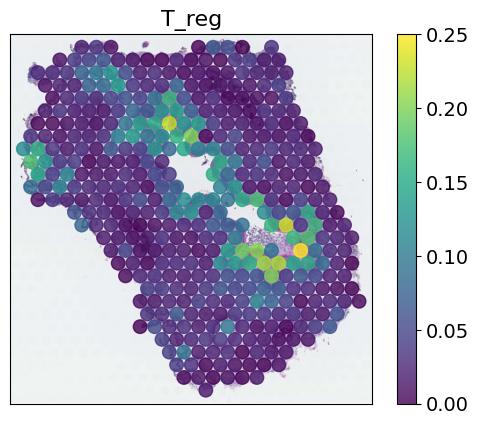

 55%|█████▍    | 6/11 [00:11<00:09,  1.81s/it]

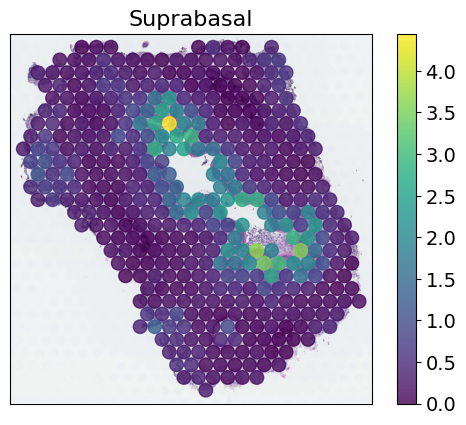

 64%|██████▎   | 7/11 [00:12<00:07,  1.79s/it]

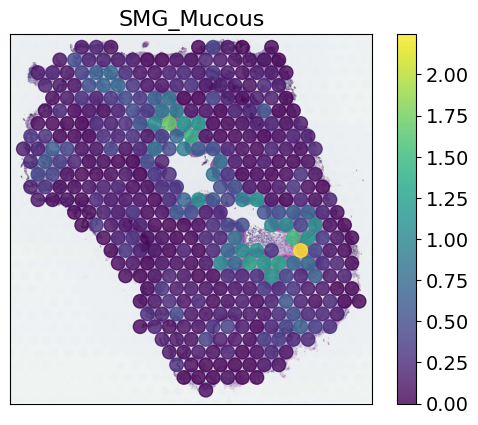

 73%|███████▎  | 8/11 [00:14<00:05,  1.79s/it]

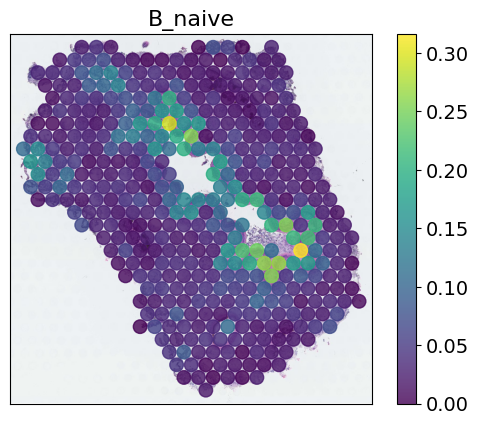

 82%|████████▏ | 9/11 [00:16<00:03,  1.79s/it]

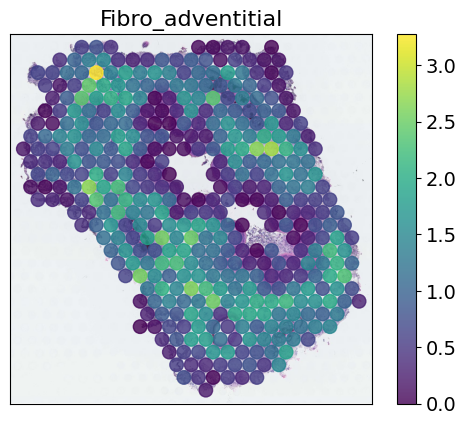

 91%|█████████ | 10/11 [00:18<00:01,  1.78s/it]

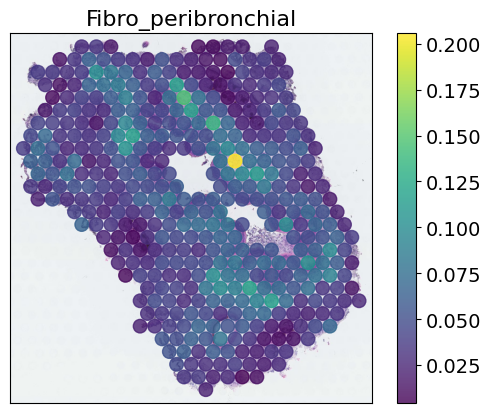

100%|██████████| 11/11 [00:19<00:00,  1.81s/it]


In [9]:
import joblib
from tqdm import tqdm


slide = "WSA_LngSP9258467"

cell_types = joblib.load("../example_data/humanlung_cell2location/cell_types.pkl")
visualize_cell_names = ['Ciliated', 'Basal', 'AT1', 'AT2', 'Chondrocyte', 'T_reg', 'Suprabasal', 'SMG_Mucous', 'B_naive', 'Fibro_adventitial', 'Fibro_peribronchial']


hist2cell_abundances = np.clip(Predictions[slide]['cell_abundance_predictions'], a_min=0, a_max=None)
coordinates = Predictions[slide]['coords']
X = coordinates[:, 0] / 4
Y = coordinates[:, 1] / 4

jpg_path = '../example_data/humanlung_cell2location/'+slide+'_low_res.jpg'
img = Image.open(jpg_path)


for i in tqdm(range(len(visualize_cell_names))):
    cell_idx = cell_types.index(visualize_cell_names[i])
    plot_cell_abundance(img, X, Y, hist2cell_abundances[:, cell_idx], cell_types[cell_idx], cmap='viridis')

Follow the same steps, we visualize the cell abundance predictions in `Fig 2`:

In [10]:
case = "A37"

model = Hist2Cell(vit_depth=3)
checkpoint = torch.load("../model_weights/humanlung_cell2location_leave_"+case+"_out.pth")
model.load_state_dict(checkpoint)
model = model.to(device)

In [11]:
test_slides = open("../train_test_splits/humanlung_cell2location/test_leave_"+case+".txt").read().split('\n')
test_slides

['WSA_LngSP9258464',
 'WSA_LngSP9258468',
 'WSA_LngSP10193347',
 'WSA_LngSP10193348']

In [12]:
from torch_geometric.loader import NeighborLoader
from tqdm import tqdm
import torch_geometric
torch_geometric.typing.WITH_PYG_LIB = False
from torch_geometric.data import Batch
import numpy as np
from scipy.stats import pearsonr


hop = 2
subgraph_bs = 16
test_graph_list = list()
for item in test_slides:
    test_graph_list.append(torch.load(os.path.join("../example_data/humanlung_cell2location", item+'.pt')))
test_dataset = Batch.from_data_list(test_graph_list)

test_loader = NeighborLoader(
    test_dataset,
    num_neighbors=[-1]*hop,
    batch_size=subgraph_bs,
    directed=False,
    input_nodes=None,
    shuffle=False,
    num_workers=2,
)

with torch.no_grad():
    model.eval()
    test_cell_pred_array = []
    test_cell_label_array = []
    test_cell_pos_array = []
    for graph in tqdm(test_loader):
        x = graph.x.to(device)
        y = graph.y.to(device)
        pos = graph.pos.to(device)
        edge_index = graph.edge_index.to(device)
        cell_label = y[:, 250:]
        cell_pred = model(x=x, edge_index=edge_index)

        center_num = len(graph.input_id)
        center_cell_label = cell_label[:center_num, :]
        center_cell_pred = cell_pred[:center_num, :]
        center_cell_pos = pos[:center_num, :]
        
        test_cell_label_array.append(center_cell_label.squeeze().cpu().detach().numpy())
        test_cell_pred_array.append(center_cell_pred.squeeze().cpu().detach().numpy())
        test_cell_pos_array.append(center_cell_pos.squeeze().cpu().detach().numpy())
        

    if len(test_cell_pred_array[-1].shape) == 1:
        test_cell_pred_array[-1] = np.expand_dims(test_cell_pred_array[-1], axis=0)
    test_cell_pred_array = np.concatenate(test_cell_pred_array)
    if len(test_cell_label_array[-1].shape) == 1:
        test_cell_label_array[-1] = np.expand_dims(test_cell_label_array[-1], axis=0)
    test_cell_label_array = np.concatenate(test_cell_label_array)
    if len(test_cell_pos_array[-1].shape) == 1:
        test_cell_pos_array[-1] = np.expand_dims(test_cell_pos_array[-1], axis=0)
    test_cell_pos_array = np.concatenate(test_cell_pos_array)
    

Predictions = dict()
for slide_no in range(len(test_slides)):
    indices = np.where(test_dataset.batch.numpy() == slide_no)
    test_cell_pred_array_sub = test_cell_pred_array[indices]
    test_cell_label_array_sub = test_cell_label_array[indices]
    test_cell_pos_arraay_sub = test_cell_pos_array[indices]
    
    test_cell_abundance_all_pearson_average = 0.0
    test_cell_pearson_list = []
    for i in range(test_cell_pred_array_sub.shape[1]):
        r, p = pearsonr(test_cell_pred_array_sub[:, i], test_cell_label_array_sub[:, i])
        test_cell_abundance_all_pearson_average = test_cell_abundance_all_pearson_average + r
        test_cell_pearson_list.append(r)
    test_cell_abundance_all_pearson_average = test_cell_abundance_all_pearson_average / test_cell_pred_array_sub.shape[1]
    
    Predictions[test_slides[slide_no]] = {
        'cell_abundance_predictions': test_cell_pred_array_sub,
        'cell_abundance_labels': test_cell_label_array_sub,
        'coords': test_cell_pos_arraay_sub,
    }
    
    print("slide %s has PCC:%f" % (test_slides[slide_no], test_cell_abundance_all_pearson_average)) 

100%|██████████| 468/468 [00:53<00:00,  8.68it/s]


slide WSA_LngSP9258464 has PCC:0.301639
slide WSA_LngSP9258468 has PCC:0.270929
slide WSA_LngSP10193347 has PCC:0.233635
slide WSA_LngSP10193348 has PCC:0.323463


  0%|          | 0/3 [00:00<?, ?it/s]

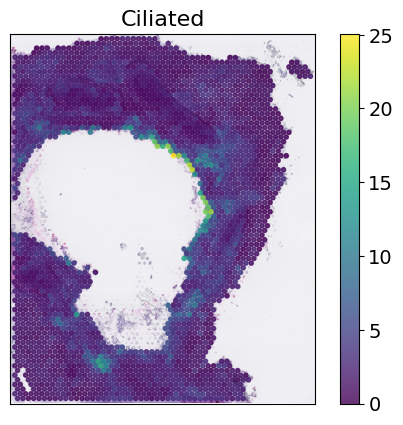

 33%|███▎      | 1/3 [00:02<00:05,  2.53s/it]

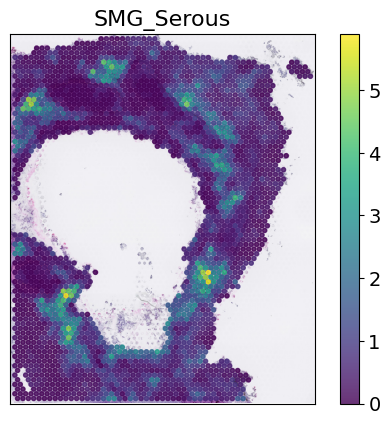

 67%|██████▋   | 2/3 [00:04<00:02,  2.36s/it]

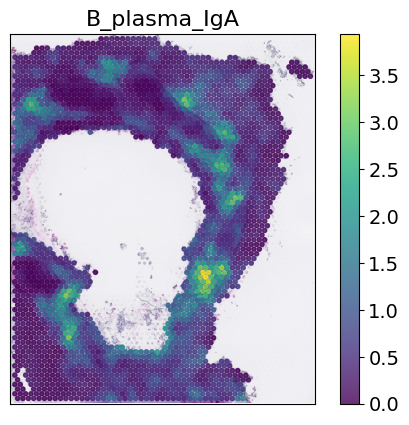

100%|██████████| 3/3 [00:07<00:00,  2.34s/it]


In [13]:
import joblib
from tqdm import tqdm


slide = "WSA_LngSP9258464"

cell_types = joblib.load("../example_data/humanlung_cell2location/cell_types.pkl")
visualize_cell_names = ['Ciliated', 'SMG_Serous',  'B_plasma_IgA']


hist2cell_abundances = np.clip(Predictions[slide]['cell_abundance_predictions'], a_min=0, a_max=None)
coordinates = Predictions[slide]['coords']
X = coordinates[:, 0] / 4
Y = coordinates[:, 1] / 4

jpg_path = '../example_data/humanlung_cell2location/'+slide+'_low_res.jpg'
img = Image.open(jpg_path)


for i in tqdm(range(len(visualize_cell_names))):
    cell_idx = cell_types.index(visualize_cell_names[i])
    plot_cell_abundance(img, X, Y, hist2cell_abundances[:, cell_idx], cell_types[cell_idx], cmap='viridis', s=9)